# Practice Exercise: Scikit-Learn 3
### Model Evaluation

### Objectives

As in the [SK3 Tutorial](https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-model-evaluation/), the objective of this practice notebook is to illustrate how you can evaluate machine learning algorithms using various performance metrics. We will show two examples of this: one for classification and one for regression.

You will use **stratified 5-fold cross-validation with 2 repetitions** during training. For testing, you will use the fine-tuned model for prediction **without** any cross-validation for simplicity.

In `GridSearchCV()`, try setting `n_jobs` to -2 for shorter run times with parallel processing. Here, -2 means use all core except 1. See [SK5 Tutorial](https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-5-advanced-topics-pipelines-statistical-model-comparison-and-model-deployment/) for more details.

## Part 1: Evaluating Classifiers

In the previous practices, you cleaned and transformed the raw `income data` and renamed the `income` column as `target` (with high income being the positive class). Including `target`, the cleaned data consists of 42 columns and 45,222 rows. Each column is numeric and between 0 and 1.

### Exercise 0: Modeling Preparation

- Read in the clean data `us_census_income_data_clean_encoded.csv` on GitHub [here](https://github.com/vaksakalli/datasets). 
- Randomly sample 5000 rows using a random seed of 999.
- Split the sampled data as 70% training set and the remaining 30% test set using a random seed of 999. 
- Remember to separate `target` during the splitting process. 

In [1]:
import numpy as np
np.random.seed(999)

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# so that we can see all the columns
pd.set_option('display.max_columns', None) 

df = pd.read_csv('us_census_income_data_clean_encoded.csv')

print(df.shape)
df.head().round(3)

(45222, 42)


,age,education_num,race,gender,hours_per_week,native_country,capital,workclass_federal_gov,workclass_local_gov,workclass_private,workclass_self_emp_inc,workclass_self_emp_not_inc,workclass_state_gov,workclass_without_pay,marital_status_divorced,marital_status_married_af_spouse,marital_status_married_civ_spouse,marital_status_married_spouse_absent,marital_status_never_married,marital_status_separated,marital_status_widowed,occupation_adm_clerical,occupation_armed_forces,occupation_craft_repair,occupation_exec_managerial,occupation_farming_fishing,occupation_handlers_cleaners,occupation_machine_op_inspct,occupation_other_service,occupation_priv_house_serv,occupation_prof_specialty,occupation_protective_serv,occupation_sales,occupation_tech_support,occupation_transport_moving,relationship_husband,relationship_not_in_family,relationship_other_relative,relationship_own_child,relationship_unmarried,relationship_wife,target
0,0.301,0.800,1,1,0.398,1,0.063,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.452,0.800,1,1,0.122,1,0.042,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.288,0.533,1,1,0.398,1,0.042,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.493,0.400,0,1,0.398,1,0.042,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.151,0.800,0,0,0.398,0,0.042,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [2]:
num_samples = 5000
df_sample = df.sample(n=num_samples, random_state=999).reset_index(drop=True)
df_sample.shape

(5000, 42)

In [3]:
from sklearn.model_selection import train_test_split
target = df_sample['target']
Data_df = df_sample.drop(columns = 'target')
D_train, D_test, t_train, t_test = train_test_split(Data_df.values, 
                                                    target.values, 
                                                    test_size=0.3, 
                                                    random_state=999)

In [4]:
print(D_train.shape)
print(D_test.shape)
print(t_train.shape)
print(t_test.shape)

(3500, 41)
(1500, 41)
(3500,)
(1500,)


### Exercise 1

Get a value counts of the target feature levels in the sample data. Do you see a class imbalance problem? In this case, which performance metrics would you prefer?

**HINT:**

For a list of scorers as a **string** that you can pass into `cross_val_score()` or `GridSearchCV()` methods, please try this:
```Python
from sklearn import metrics 
metrics.SCORERS.keys()
```

`Scikit-Learn` has a module named `metrics` which contains different performance metrics for classifiers and regressors. For a list of metrics **methods** that you can use, please see official Scikit-Learn documentation on model evaluation [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [5]:
target.value_counts(normalize=True)

0    0.7446
1    0.2554
Name: target, dtype: float64

In [6]:
print('Positive class is only 25%. There surely is a class imbalance problem.')
print('In this case, F1-Score or AUC would be preferred.')

Positive class is only 25%. There surely is a class imbalance problem.
In this case, F1-Score or AUC would be preferred.


### Exercise 2

Fit and fine-tune a DT model using the **train** data. For fine-tuning, consider max_depth values in {3, 5, 7, 10} and min_samples_split values in {2, 5, 15, 20}. Display the best parameter values and the best estimator found during the grid search.

In [7]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=2, 
                                    random_state=999)

In [8]:
from sklearn.tree import DecisionTreeClassifier
model_DT = DecisionTreeClassifier(random_state=999)

scoring_metric = 'roc_auc'

params_DT = {'max_depth': [3, 5, 7, 10],
             'min_samples_split': [2, 5, 15, 20]}

gs_DT = GridSearchCV(estimator=model_DT, 
                      param_grid=params_DT, 
                      cv=cv_method,
                      verbose=1, 
                      scoring=scoring_metric,
                      n_jobs=-2,
                      return_train_score=True)

In [9]:
gs_DT.fit(D_train, t_train);

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [10]:
gs_DT.best_params_

{'max_depth': 7, 'min_samples_split': 20}

In [11]:
gs_DT.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_split=20, random_state=999)

In [12]:
gs_DT.best_score_

0.877334400600526

### Exercise 3

Get the predictions for the test data using the best estimator. You can achieve this via the following:
```Python
t_pred = gs_DT.predict(D_test)
```
Using the predictions on the **test** data, display the confusion matrix. In addition, compute the following metrics:
1. Accuracy rate
2. Error (misclassification) rate
3. Precision
4. Recall (TPR)
5. F1-Score
6. AUC

In [13]:
t_pred = gs_DT.predict(D_test)

In [14]:
from sklearn import metrics
metrics.confusion_matrix(t_test, t_pred)

array([[1063,   62],
       [ 169,  206]], dtype=int64)

In [15]:
metrics.accuracy_score(t_test, t_pred)

0.846

In [16]:
# error rate is 1 - accuracy
1 - metrics.accuracy_score(t_test, t_pred)

0.15400000000000003

In [17]:
metrics.precision_score(t_test, t_pred)

0.7686567164179104

In [18]:
metrics.recall_score(t_test, t_pred)

0.5493333333333333

In [19]:
metrics.f1_score(t_test, t_pred)

0.640746500777605

In [20]:
metrics.roc_auc_score(t_test, t_pred)

0.7471111111111111

In [21]:
print(metrics.classification_report(t_test, t_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1125
           1       0.77      0.55      0.64       375

    accuracy                           0.85      1500
   macro avg       0.82      0.75      0.77      1500
weighted avg       0.84      0.85      0.84      1500



### Exercise 4

Visualize an ROC curve by calculating prediction scores using the `predict_proba` method in `Scikit-learn`.

In [22]:
t_prob = gs_DT.predict_proba(D_test)
t_prob[0:10]

array([[0.99267101, 0.00732899],
       [0.52769679, 0.47230321],
       [0.        , 1.        ],
       [0.38362069, 0.61637931],
       [0.99267101, 0.00732899],
       [0.44444444, 0.55555556],
       [0.99267101, 0.00732899],
       [0.52769679, 0.47230321],
       [0.84563758, 0.15436242],
       [0.99267101, 0.00732899]])

In [23]:
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob[:, 1])
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8926838518518518

In [24]:
import pandas as pd
df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df.head()

,fpr,tpr
0,0.000000,0.000000
1,0.001778,0.245333
2,0.002667,0.277333
3,0.002667,0.282667
4,0.016889,0.368000


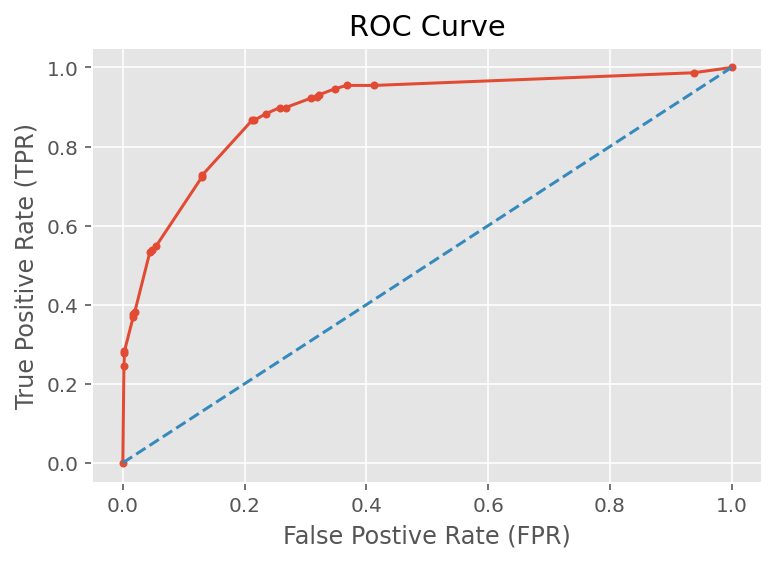

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
    
ax = df.plot.line(x='fpr', y='tpr', title='ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show();

### Extra Exercise 1: Visualising the confusion matrix via a heatmap

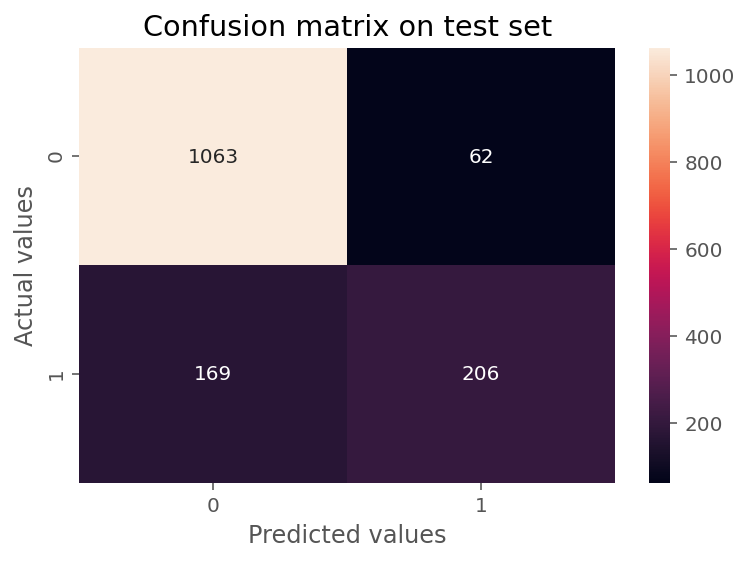

In [26]:
import seaborn as sns
cf_matrix = metrics.confusion_matrix(t_test, t_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
ax.set(xlabel='Predicted values', ylabel='Actual values')
ax.set_title("Confusion matrix on test set")
plt.show()

### Extra Exercise 2: Shifting the prediction threshold

Behind the scenes, `Scikit-learn` will calculate the probability score of the prediction via `predict_proba`. For most ML algorithms, `Scikit-learn` uses a prediction threshold of 0.5 in generating predictions via `predict`. For example, suppose an instance to be predicted has a probability score of 0.77. Since its score is higher than 0.5, `Scikit-learn` will classify it as a "positive" class. On the other hand, if the probability score was 0.23, then it would be labelled as "negative" class. 

So, what if we change the prediction threshold? How would precision, recall, and accuracy change?

In [27]:
precision, recall, thresholds = metrics.precision_recall_curve(t_test, t_prob[:,1], pos_label=1)
accuracy = [metrics.accuracy_score(t_test, t_prob[:,1]>=t) for t in thresholds]
results = pd.DataFrame({"Precision": precision[1:], 
                        "Recall": recall[1:], 
                        "Threshold": thresholds,
                        "Accuracy": accuracy})

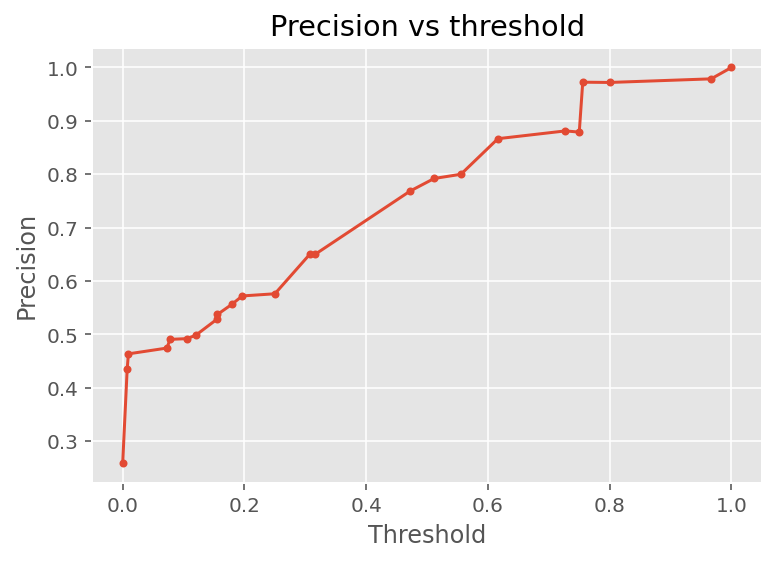

In [28]:
ax = results.plot.line(x='Threshold', y='Precision', title='Precision vs threshold', legend=False, marker = '.')
ax.set_xlabel("Threshold")
ax.set_ylabel("Precision")
plt.show();

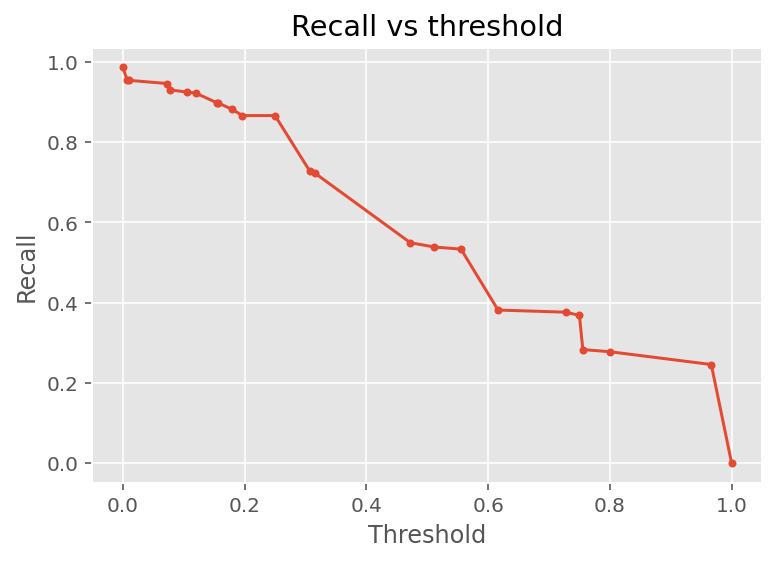

In [29]:
ax = results.plot.line(x='Threshold', y='Recall', title='Recall vs threshold', legend=False, marker = '.')
ax.set_xlabel("Threshold")
ax.set_ylabel("Recall")
plt.show();

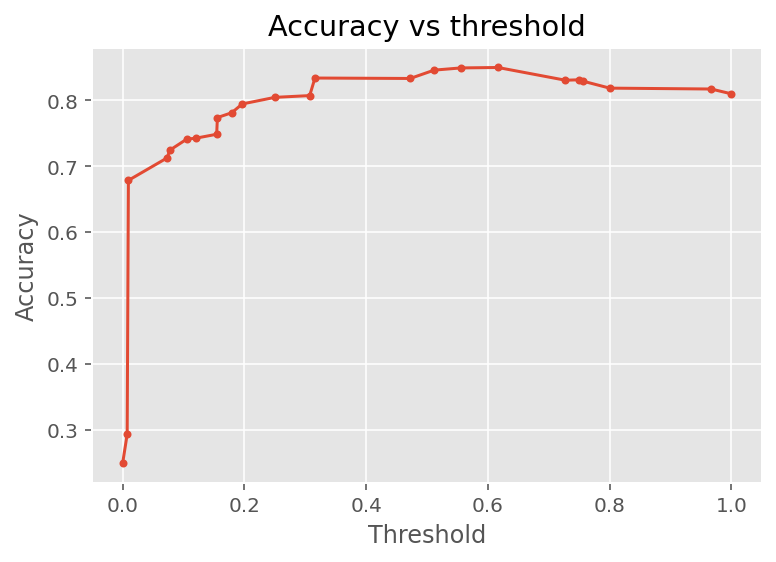

In [30]:
ax = results.plot.line(x='Threshold',y="Accuracy", title='Accuracy vs threshold', legend=False, marker = '.')
ax.set_xlabel("Threshold")
ax.set_ylabel("Accuracy")
plt.show();

What can you infer from the visualisations above?

## Part 2: Evaluating Regressors 

### Exercise 0: Modeling Preparation
    
For evaluating regressors, we will use the **diamonds** dataset from Prac_SK1. On Canvas, you will see a CSV called 'diamonds_clean_5000.csv'. This is preprocessed diamonds dataset with a random sample of 5000 instances. Read in this dataset and display 5 random instances. Split this data as 70% training set and the remaining 30% test set using a random seed of 999. The target response is the `price`. 

In [31]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

# so that we can see all the columns
pd.set_option('display.max_columns', None) 

df = pd.read_csv('diamonds_clean_5000.csv')

print(df.shape)
df.sample(n=5, random_state=999)

(5000, 27)


,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
3581,0.110187,0.525000,0.230769,0.542831,0.097963,0.112893,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2919
3035,0.041580,0.552778,0.230769,0.439479,0.080306,0.093396,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,912
2455,0.106029,0.530556,0.211538,0.533520,0.097793,0.112264,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2365
3014,0.272349,0.497222,0.346154,0.681564,0.123939,0.139937,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11666
3114,0.114345,0.466667,0.326923,0.554935,0.100509,0.111635,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1881


In [32]:
# last column is target feature
target = df.iloc[:, -1]

# everything else is Data, i.e., the set of descriptive features
Data = df.iloc[:, :-1]

In [33]:
D_train, D_test, t_train, t_test = train_test_split(Data.values, 
                                                    target.values, 
                                                    test_size=0.3, 
                                                    random_state=999)

### Exercise 1

Fit and fine-tune a DT regressor model using the **train** data. For fine-tuning, consider max_depth values in {10, 20, 30, 40} and min_samples_split values in {15, 25, 35}. For scoring, use **MSE (mean squared error)**. Display the best parameter values and the best estimator found during the grid search.

In [34]:
from sklearn.tree import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor(random_state=999)

params_DT = {'max_depth': [10, 20, 30, 40], 'min_samples_split': [15, 25, 35]}
    
scoring_metric = 'neg_mean_squared_error'

gs_DT_regressor = GridSearchCV(estimator=dt_regressor, 
                  param_grid=params_DT, 
                  cv=cv_method,
                  verbose=1, 
                  n_jobs=-2,
                  scoring=scoring_metric)

gs_DT_regressor.fit(D_train, t_train);

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [35]:
gs_DT_regressor.best_params_

{'max_depth': 30, 'min_samples_split': 25}

In [36]:
gs_DT_regressor.best_estimator_

DecisionTreeRegressor(max_depth=30, min_samples_split=25, random_state=999)

### Exercise 2
    
Get the predictions for the test data using the best estimator. You can achieve this via the following:
```Python
t_pred = gs_DT_regressor.predict(D_test)
```
Using the predictions on the **test** data, compute the following metrics:
1. MSE
2. RMSE
3. Mean absolute error (MAE)
4. $R^2$   

In [37]:
t_pred = gs_DT_regressor.predict(D_test)

In [38]:
np.sqrt(metrics.mean_squared_error(t_test, t_pred))

870.6129342581762

In [39]:
metrics.mean_absolute_error(t_test, t_pred)

451.2306706423932

In [40]:
metrics.r2_score(t_test, t_pred)

0.953503223206511

### Exercise 3

Create a histogram of residuals for your DT model. How does it look in terms of shape and spread?

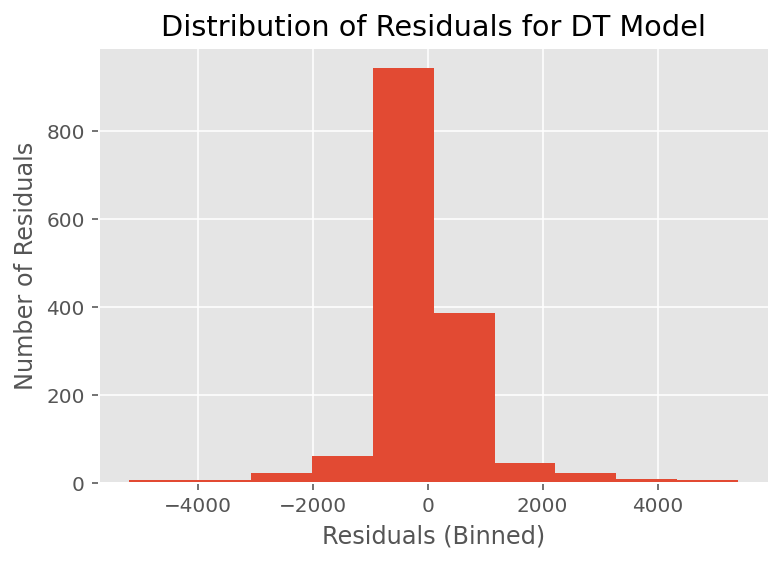

In [41]:
residuals_dt = t_test - t_pred

plt.hist(residuals_dt)
plt.xlabel("Residuals (Binned)")
plt.ylabel("Number of Residuals")
plt.title("Distribution of Residuals for DT Model")
plt.show()

### Exercise 4 (Optional)

In Exercise 2, we obtain an MSE around 870 USD. Without any domain knowledge on diamond prices, how do we conclude whether the range of prediction errors (i.e., residuals) is "reasonable"? Let's use standardised residuals $e$ defined as follows: 

$$e = \frac{\varepsilon-\bar{\varepsilon}}{\sigma(\varepsilon)}$$

where residuals are denoted by $\varepsilon$ with $\bar{\varepsilon}$ and $\sigma$ denoting their mean and standard deviation respectively. 

**HINT:**

Consider plotting a histogram of standardised errors.

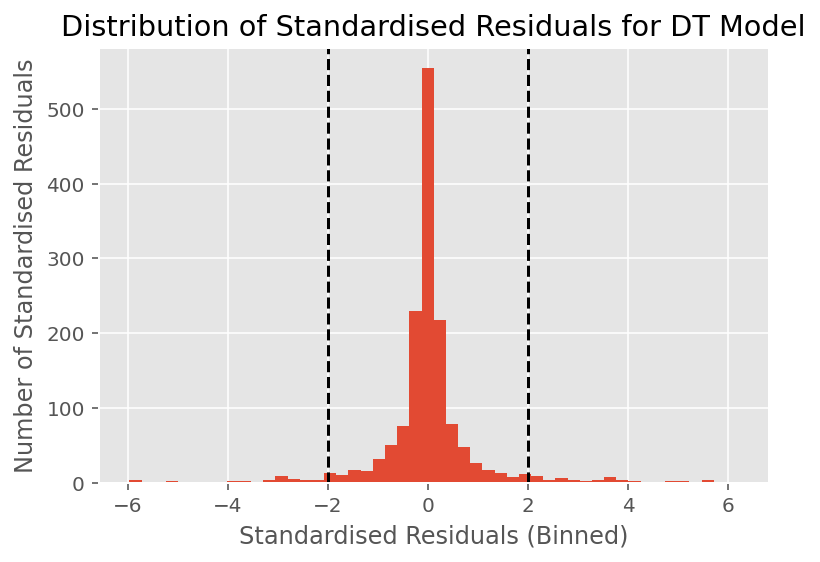

In [42]:
standardised_residuals = (residuals_dt - np.mean(residuals_dt))/np.std(residuals_dt)
plt.hist(standardised_residuals, bins=50)
plt.xlabel("Standardised Residuals (Binned)")
plt.ylabel("Number of Standardised Residuals")
plt.axvline(x=-2, color='black', ls='--')
plt.axvline(x=+2, color='black', ls='--')
plt.title("Distribution of Standardised Residuals for DT Model")
plt.show()

Here, standardisation is accomplished by a z-score transformation. The standardised residuals will have a zero mean and a standard deviation of 1. In the histogram, we observe that majority of standardised residuals fall within +/- 2 standard deviations (the dotted vertical black lines), indicating that the truly large residuals are unlikely and therefore the DT regressor has a reasonable predictive power.

***
www.featureranking.com